
# Проведение и анализ результатов А/В-теста для увеличения выручки интернет-магазина

**Описание проекта**

Сейчас мы в роли аналитика крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Описание данных**

В нашем распоряжении 3 датасета:

Файл **/datasets/hypothesis.csv**:
- **Hypothesis** — краткое описание гипотезы;
- **Reach** — охват пользователей по 10-балльной шкале;
- **Impact** — влияние на пользователей по 10-балльной шкале;
- **Confidence** — уверенность в гипотезе по 10-балльной шкале;
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл **/datasets/orders.csv**:
- **transactionId** — идентификатор заказа;
- **visitorId** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

Файл **/datasets/visitors.csv**:
- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

**Цели нашего исследования:**
- приоритизировать гипотезы;
- запустить A/B-тест;
- проанализировать результаты.

На следующем этапе загрузим и подготовим данные к анализу.

## Загрузим и подготовим данные к анализу

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
pd.set_option('display.max_colwidth', 0)

In [2]:
# загрузим данные
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# функция для получения основной информации о датафрейме
def first_analysis(table):
    print('Первые 5 строк датафрейма:')
    display(table.head(5))
    print('Общая информация о датафрейме:')
    display(table.info())
    print('Сводная статистика:')
    display(table.describe())
    print('Количество пропусков:')
    display(table.isna().sum())
    print('Количество явных дубликатов:')
    display(table.duplicated().sum())

# получим основную информацию о датафреме с гипотезами
first_analysis(hypothesis)

Первые 5 строк датафрейма:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


None

Сводная статистика:


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Количество пропусков:


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Количество явных дубликатов:


0

Таблица с информацией о гипотезах содержит 9 строк и 5 столбцов. Пропущенные значения отсутствуют. Явные дубликаты в таблице так же отсутствуют. В набор данных входят 2 типа данных: целые числа и строки. Все столбцы датафрейма необходимо привести к нижнему регистру для хорошего стиля.

In [4]:
# получим основную информацию о датафреме с заказами
first_analysis(orders)

Первые 5 строк датафрейма:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Сводная статистика:


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Количество пропусков:


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Количество явных дубликатов:


0

Таблица с информацией о заказах содержит 1197 строк и 5 столбцов. Пропущенные значения отсутствуют. Явные дубликаты в таблице так же отсутствуют. В набор данных входят 2 типа данных: целые числа и строки. Столбец date необходимо привести к типу datetime. Названия столбцов transactionId, visitorId необходимо привести к змеиному регистру.

In [5]:
# получим основную информацию о датафреме с пользователями
first_analysis(visitors)

Первые 5 строк датафрейма:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Сводная статистика:


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Количество пропусков:


date        0
group       0
visitors    0
dtype: int64

Количество явных дубликатов:


0

Таблица с информацией о посетителях содержит 62 строки и 3 столбца. Пропущенные значения отсутствуют. Явные дубликаты в таблице так же отсутствуют. В набор данных входят 2 типа данных: целые числа и строки. Столбец date необходимо привести к типу datetime. Названия столбцов соответствуют хорошему стилю.

In [6]:
# приведем названия столбцов к общему виду
hypothesis.columns = hypothesis.columns.str.lower() 

orders.columns = [x.replace('Id', '_id') for x in orders.columns]

In [7]:
# приведем столбцы с датой к нужному типу
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')

**Вывод:**
- загружены данные;
- названия столбцов приведены к общему виду;
- типы данных в столбцах с датами изменены;
- пропущенные значения и дубликаты в таблицах отсутствуют.

Данные готовы к дальнейшему анализу.

## Приоритизация гипотез
В файле /datasets/hypothesis.csv имеется 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Фреймворк ICE рассчитаем по формуле:
**ICE = Impact (влияние) * Confidence (уверенность) / Efforts (усилия)**

Фреймворк RICE рассчитаем по формуле: 
**RICE = Reach (охват) * Impact (влияние) * Confidence (уверенность) / Efforts (усилия)**

### Применим фреймворк ICE для приоритизации гипотез.

In [8]:
# рассчитаем ICE
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)

hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE: "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

### Применим фреймворк RICE для приоритизации гипотез.

In [9]:
# рассчитаем RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". В данном случае порядок изменился.

### Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. 

In [10]:
hypothesis.sort_values(by='RICE', ascending=False)  

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Приоритизация гипотез при применении RICE вместо ICE изменилась в связи с тем, что параметр Reach у гипотез под номером 7 и 2 выше, чем у остальных. В обоих случаях на своих местах остались гипотезы с индексом 6 и 4.

## Анализ A/B-теста
Ранее мы получили результаты теста, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

### Построим график кумулятивной выручки по группам.

Перед тем, как приступить к анализу результатов А/В теста, проверим, есть ли пользователи, входящие в обе группы.

In [11]:
# проверим сегменты на совпадение пользователей
group_a = orders[orders['group'] == 'A']['visitor_id']
group_b = orders[orders['group'] == 'B']['visitor_id']
orders_ab = orders.query('visitor_id in @group_a and visitor_id in @group_b')

print('Общее число пользователей в тесте:', orders['visitor_id'].nunique())
print('Количество пользователей в двух группах:', orders_ab['visitor_id'].nunique())
print('Доля пользователей, входящих в обе группы:', '{0:.2f}'.format(orders_ab['visitor_id'].nunique() / orders['visitor_id'].nunique()))

Общее число пользователей в тесте: 1031
Количество пользователей в двух группах: 58
Доля пользователей, входящих в обе группы: 0.06


Такие пользователи действительно есть. Примерно 6% от общего числа пользователей попали в оба сегмента теста.

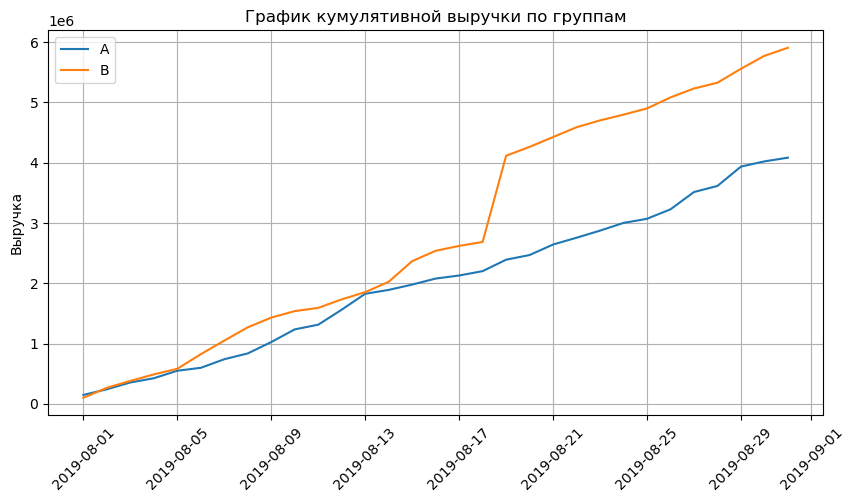

In [12]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# cтроим графики выручки группы А и В
plt.figure(figsize=(10,5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Можем видеть, что на протяжении всего теста сегмент В лидировал. Примерно 18 августа произошел резкий рост выручки в группе В, что может быть связано с крупными заказами. Вероятно, если бы не скачок в группе В, то выручки в обеих сегментах росли бы равномерно.

### Построим график кумулятивного среднего чека по группам.

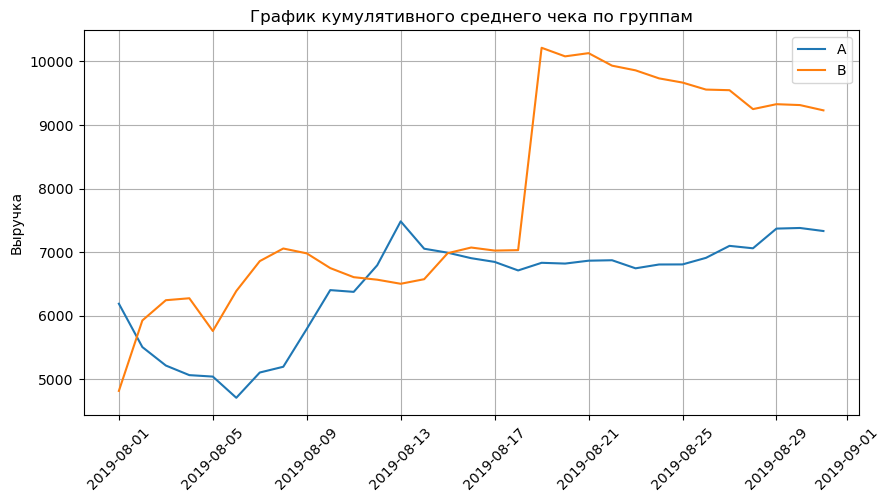

In [13]:
# cтроим графики среднего чека группы А и В
plt.figure(figsize=(10,5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Кумулятивное значение среднего чека по группам колеблется примерно до 18 августа. Также замечем резкий скачок в сегменте В 18 августа. Как уже предположили ранее, это может быть связано с крупными заказами в этот день.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

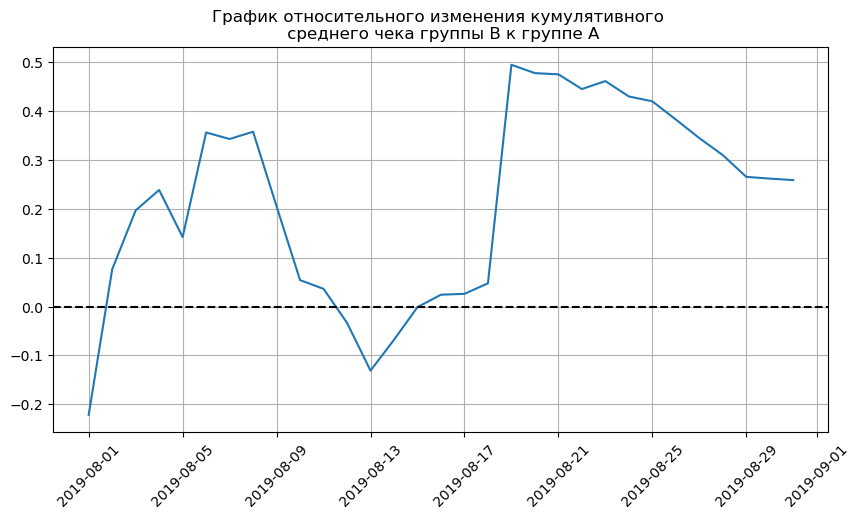

In [14]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10,5))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного \n среднего чека группы В к группе А')
plt.xticks(rotation=45)
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

График относительного изменения кумулятивного среднего чека группы В к группе А нестабилен. Результаты значиельно и резко менялись в некоторые дни. Вероятно, в эти дни были совершены аномальные заказы.

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

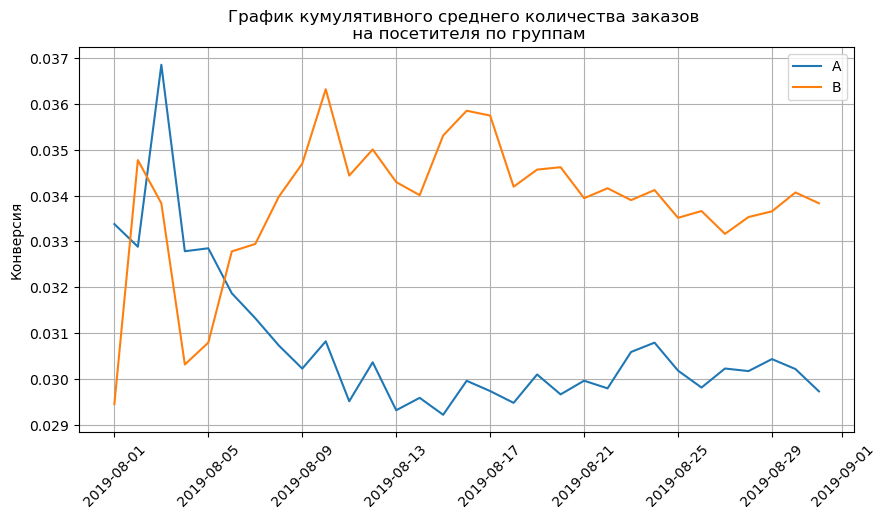

In [15]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.title('График кумулятивного среднего количества заказов \n на посетителя по группам')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

В начале теста сегмент А имел больщую конверсию. Примерно 6 августа конверсия обеих групп сравнялась. Но в итоге, конверсия сегмента В превысила конверсию группы А.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

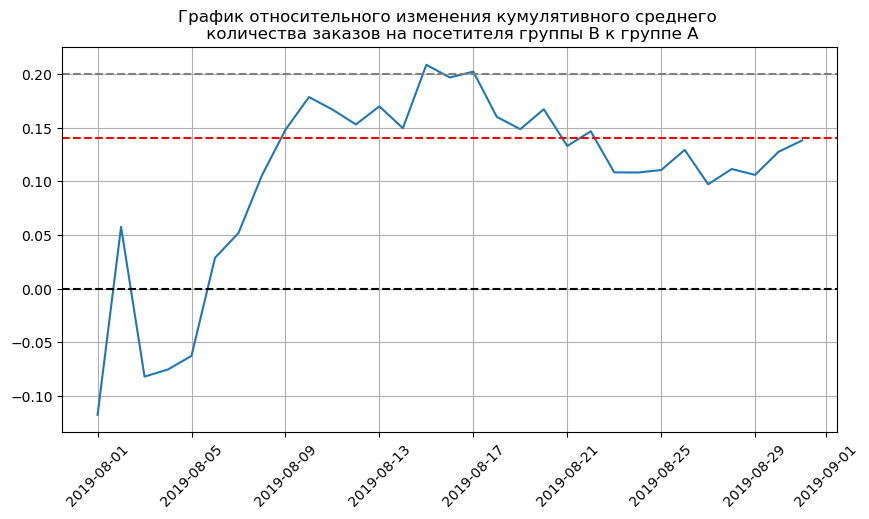

In [16]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axhline(y=0.14, color='red', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего \n количества заказов на посетителя группы B к группе A')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Почти с самого начала теста группа В лидирует по конверсии, однако приблизительно 3 августа ситуация ухудшается. Максимальный прирост (в 20%) можем зафиксировать 15-17 августа. Впоследствии конверсия группы В зафиксировалась около прироста в 14% относительно группы А.

### Построим точечный график количества заказов по пользователям.

      visitor_id  orders
1023  4256040402  11    
591   2458001652  11    
569   2378935119  9     
487   2038680547  8     
44    199603092   5     
744   3062433592  5     
55    237748145   5     
917   3803269165  5     
299   1230306981  5     
897   3717692402  5     


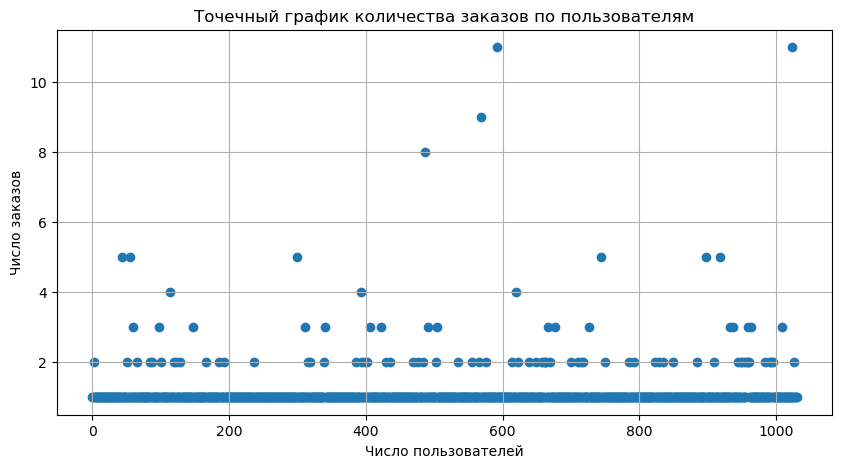

In [17]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders_by_users['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.grid()
plt.show()

Пользователей, заказавших более 3-х совсем немного. Данные значения могут быть аномалиями. Чтобы это определить, посчитаем выборочные перцентили.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [18]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей совершали больше 2-х заказов. И не более 1% пользователей - больше 4-х заказов. Примем за аномальных пользователей тех, кто совершил от 3 заказов. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов. 

### Построим точечный график стоимостей заказов.

      transaction_id  visitor_id       date  revenue group
425   590470918       1920142716 2019-08-19  1294500  B   
1196  3936777065      2108080724 2019-08-15  202740   B   
858   192721366       1316129916 2019-08-27  93940    A   
1136  666610489       1307669133 2019-08-13  92550    A   
744   3668308183      888512513  2019-08-27  86620    B   
682   1216533772      4266935830 2019-08-29  78990    B   
662   1811671147      4266935830 2019-08-29  78990    A   
743   3603576309      4133034833 2019-08-09  67990    A   
1103  1348774318      1164614297 2019-08-12  66350    A   
1099  316924019       148427295  2019-08-12  65710    A   


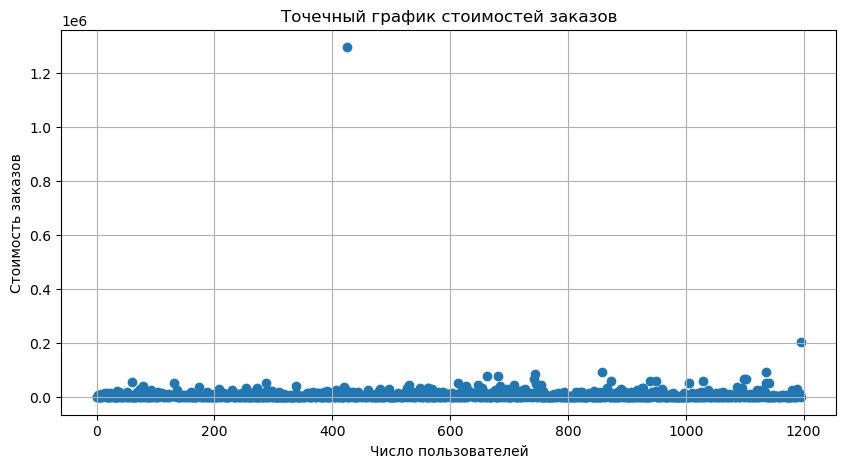

In [19]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

Построим еще один более наглядный график.

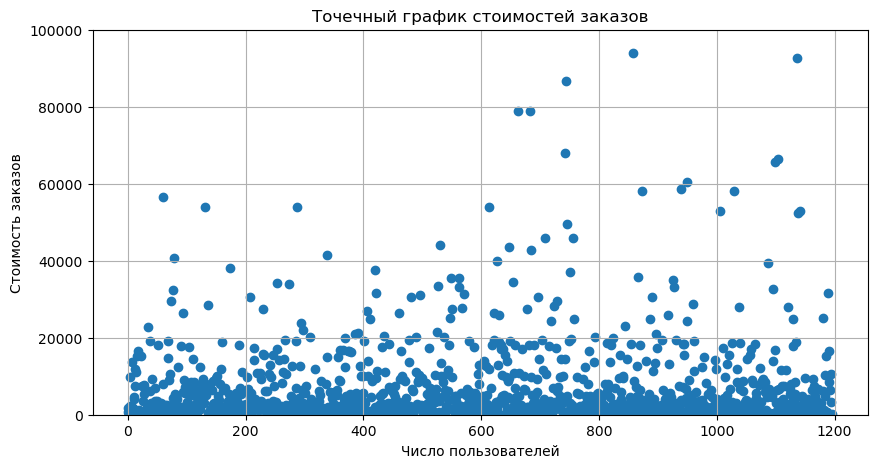

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.ylim(0, 100000) 
plt.grid()
plt.show()

Заказов стоимостью 40 000 не так много. Присутствуют выбросы в районе 80 000 - 1 250 000. Заказ на сумму 1 250 000 выглядит слишком аномально. Найдем выборочные перцентили.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [21]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более, чем у 5% заказов чек дороже 28 000. И не больше, чем у 1% заказов - дороже 58 233. Примем за аномальных пользователей тех, кто совершил заказ дороже 35 000. Так мы уберём от 1% до 5% пользователей с дорогими заказами. 

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [22]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    orders_A_daily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders'] 
sample_A = pd.concat([orders_by_users_A['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01  24              148579           21               
1 2019-08-02  20              93822            24               
2 2019-08-03  24              112473           16               
3 2019-08-04  16              70825            17               
4 2019-08-05  25              124218           23               

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0  101217           24                  148579                
1  165531           44                  242401                
2  114248           68                  354874                
3  108571           84                  425699                
4  92428            109                 549917                

   ordersCummulativeB  revenueCummulativeB  visitors_per_date_A  \
0  21                  101217               719                   
1  45                  266748               619                   
2  61                  380996

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем количестве заказов между группами есть.

In [23]:
print('P-value:',"{0:.5f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print('Относительный прирост среднего группы В к конверсии группы А:',"{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value: 0.01679
Относительный прирост среднего группы В к конверсии группы А: 0.138


P-value оказался меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 13.8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в среднем чеке заказа между группами нет. Альтернативная: различия в среднем чеке между группами есть.

In [24]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост средней выручки группы В к выручке группы А:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Относительный прирост средней выручки группы В к выручке группы А: 0.259


P-value в данном случае больше 0.05 - статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между сегментами 25.9%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами без учета выбросов нет. Альтернативная: различия в среднем количестве заказов между группами без учета выбросов есть.

In [25]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 3]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 35000]['visitor_id']
ab_normal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('Относительный прирост среднего группы В к конверсии группы А:','{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)) 

P-value: 0.01390
Относительный прирост среднего группы В к конверсии группы А: 0.155


Как и в случае с "сырыми данными", статистическая значимость достигнута. Сегмент В выше сегмента А.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы. Нулевая: различий в среднем чеке заказа между группами без учета выбросов нет. Альтернативная: различия в среднем чеке между группами без учета выбросов есть.

In [26]:
print(
    'P-value:','{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост средней выручки группы В к выручке группы А:',"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.874
Относительный прирост средней выручки группы В к выручке группы А: 0.025


P-value также больше 0.05 - статистически значимых отличий в среднем чеке после удаления выбросов между группами нет. Однако, изменилось относительное различие среднего чека между сегментами - 2.5%.

### Примем решение по результатам теста и объясним его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

В ходе анализа получили следующие результаты:
- График различия среднего чека колеблется, что говорит о наличии аномалий.
- График различия конверсии между группами показал, что результаты группы B лучше группы A: имели тенденцию к росту и зафиксировались около прироста в 14% относительно группы А.
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- По среднему чеку между группами и по сырым данным, и после удаления аномалий статистически значимых различий нет.

Исходя из фактов выше, нам с коллегами из отдела маркетинга необходимо остановить тест и зафиксировать победу группы В.